# Описание проекта 

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Требуется проверить две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Загрузка модулей и данных

Загрузка модулей

In [1]:
%matplotlib inline
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

Загрузка данных:

In [2]:
try:
    calls = pd.read_csv("/datasets/calls.csv")
    internet = pd.read_csv("/datasets/internet.csv", index_col=0) #Таблица для интернет трафика уже содержит индексный столбец 
    messages = pd.read_csv("/datasets/messages.csv")
    tariffs = pd.read_csv("/datasets/tariffs.csv")
    users = pd.read_csv("/datasets/users.csv")
    
except:
    calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
    messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')
    tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')

## Ознакомление с данными

Таблица `users`

In [3]:
display(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Содержимое таблицы `users` соответствует описанию. Пропуски по всей видимости отсутствуют. 38 пользователе из 500 сменили тариф, это необходимо учитывать при анализе их параметров.

In [4]:
for name, table in {'calls' : calls, 'messages' : messages, 'internet' : internet, 'tariffs' : tariffs}.items():
    print()
    print('-'*70)
    print('Таблица:', name)
    print('-'*70)
    display(table.info())
    display(table.head())



----------------------------------------------------------------------
Таблица: calls
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



----------------------------------------------------------------------
Таблица: messages
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



----------------------------------------------------------------------
Таблица: internet
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000



----------------------------------------------------------------------
Таблица: tariffs
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Содержимое остальных таблиц соответствует описанию, пропуски в таблицах отсутствуют. Даты звонков/сообщений/интернет трафика представлены в текстовом виде и должны быть преобразованы в формат datetime. Также даты действий могут приходится на период вне действия тарифа (до `reg_time` или после `churn_date`). Проверим наличие таких данных:

In [5]:
#Добавим в таблицу звонков дату подключения и отключения тарифа:
calls_upt = calls.join(users.set_index('user_id')[['churn_date', 'reg_date']], on='user_id')

print('Звонков до подключения тарифа:', len(calls_upt[calls_upt['call_date'] < calls_upt['reg_date']]))
print('Звонков после отключения тарифа:', len(calls_upt[calls_upt['call_date'] > calls_upt['churn_date']]), '\n')

#Добавим в таблицу сообщений дату подключения и отключения тарифа:
messages_upt = messages.join(users.set_index('user_id')[['churn_date', 'reg_date']], on='user_id')

print('Сообщений до подключения тарифа:', len(messages_upt[messages_upt['message_date'] < messages_upt['reg_date']]))
print('Сообщений после отключения тарифа:', len(messages_upt[messages_upt['message_date'] > messages_upt['churn_date']]), '\n')

#Добавим в таблицу сообщений дату подключения и отключения тарифа:
internet_upt = internet.join(users.set_index('user_id')[['churn_date', 'reg_date']], on='user_id')

print('Интернет сессий до подключения тарифа:', len(internet_upt[internet_upt['session_date'] < internet_upt['reg_date']]))
print('Интернет сессий после отключения тарифа:', len(internet_upt[internet_upt['session_date'] > internet_upt['churn_date']]))

Звонков до подключения тарифа: 0
Звонков после отключения тарифа: 0 

Сообщений до подключения тарифа: 0
Сообщений после отключения тарифа: 0 

Интернет сессий до подключения тарифа: 0
Интернет сессий после отключения тарифа: 0


**Вывод**

Все данные в рамках действия тарифных планов, дополнительные действия не требуются.

## Предобработка данных

### Преобразование дат, обработка действий в месяц подключения/отключения тарифа  

Преобразуем сведения о датах в формат `datetime` и добавим в таблицы месяц совершения действий, а также месяц и день подключения/отключения тарифа. По условиию все данные должны приходиться на 2018 год, при преобразовании будем проверять так ли это:

In [6]:
#Для единообразия во всех таблицах переименуем дату совершения действия:
calls_upt.rename({'call_date' : 'action_date'}, axis=1, inplace=True)
messages_upt.rename({'message_date' : 'action_date'}, axis=1, inplace=True)
internet_upt.rename({'session_date' : 'action_date'}, axis=1, inplace=True)


for table in [calls_upt, messages_upt, internet_upt]:
    table['action_date'] = pd.to_datetime(table['action_date'])
    table['month'] = table['action_date'].dt.month
    table['churn_month'] = pd.to_datetime(table['churn_date']).dt.month
    table['churn_day'] = pd.to_datetime(table['churn_date']).dt.day
    table['reg_month'] = pd.to_datetime(table['reg_date']).dt.month
    table['reg_day'] = pd.to_datetime(table['reg_date']).dt.day
    vname = [name for name in globals() if globals()[name] is table]
    for_delete = table.query('action_date.dt.year != 2018').index
    table.drop(for_delete, inplace=True)
    print(f'В таблице {vname[1]} удалено {len(for_delete)} записей не за 2018 год')
   

В таблице calls_upt удалено 0 записей не за 2018 год
В таблице messages_upt удалено 0 записей не за 2018 год
В таблице internet_upt удалено 0 записей не за 2018 год


Действия пользователей в месяц подключения или отключения тарифа должны учитываться отдельно.  
Можно полностью их исключить, изменить пропорционально количеству дней пользования тарифом, или использовать другой подход. Выбор правильного подхода требует дополнительного изучения, выходящего за рамки текущего исследования.  
Для простоты исключим действия лиц в месяц смены тарифа, если они пользовались тарифом менее 10 дней (день поключения больше 20, день отключения меньше 10):

In [7]:
calls_to_exclude = (
  (calls_upt['month'] == calls_upt['reg_month']) & (calls_upt['reg_day']>20)) | ((calls_upt['month'] == calls_upt['churn_month']) & (calls_upt['churn_day']<10))
print(f"Доля исключаемых звонков: {calls_to_exclude.mean():0.2%}")
calls_upt.drop(calls_upt.index[calls_to_exclude], inplace=True)

messages_to_exclude = ((messages_upt['month'] == messages_upt['reg_month']) & (messages_upt['reg_day']>20)) | ((messages_upt['month'] == messages_upt['churn_month']) & (messages_upt['churn_day']<10))
print(f"Доля исключаемых SMS-сообщений: {messages_to_exclude.mean():0.2%}")
messages_upt.drop(messages_upt.index[messages_to_exclude], inplace=True)

internet_to_exclude = ((internet_upt['month'] == internet_upt['reg_month']) & (internet_upt['reg_day']>20)) | ((internet_upt['month'] == internet_upt['churn_month']) & (internet_upt['churn_day']<10))
print(f"Доля исключаемого использования интернета: {internet_to_exclude.mean():0.2%}")
internet_upt.drop(internet_upt.index[internet_to_exclude], inplace=True)

Доля исключаемых звонков: 1.56%
Доля исключаемых SMS-сообщений: 1.51%
Доля исключаемого использования интернета: 1.54%


Доля исключенных записей находится в пределах нормы.

### Подсчет общего количества действий по месяцам 

Сгруппируем данные по отдельным пользователям по месяцам.  
При учете звонков "Мегалайн" округляет длительность до минуты, сделаем также перед суммированием:

In [8]:
calls_upt['duration'] = np.ceil(calls_upt['duration'])

calls_by_month = (calls_upt
                  .groupby(['user_id', 'month'])
                  .sum()
                  .reset_index()
                  .rename({'duration' : 'minutes_tot'}, axis=1)
                 [['user_id', 'month', 'minutes_tot']])

calls_by_month.head()

,user_id,month,minutes_tot
0,1000,6,172.0
1,1000,7,340.0
2,1000,8,408.0
3,1000,9,466.0
4,1000,10,350.0


Интернет-трафик округляется до Гб, после суммирования в течение месяца:

In [9]:
internet_by_month = (internet_upt
                         .groupby(['user_id', 'month'])
                         .sum()
                         .reset_index()
                    )
internet_by_month['gb_used'] = np.ceil(internet_by_month['mb_used']/1024)
internet_by_month.head()

,user_id,month,mb_used,churn_month,churn_day,reg_month,reg_day,gb_used
0,1000,6,23233.77,0.0,0.0,245,1225,23.0
1,1000,7,14003.64,0.0,0.0,145,725,14.0
2,1000,8,14055.93,0.0,0.0,145,725,14.0
3,1000,9,14568.91,0.0,0.0,135,675,15.0
4,1000,10,14702.49,0.0,0.0,135,675,15.0


Сообщения могут быть просто подсчитаны по месяцам:

In [10]:
messages_by_month = (messages_upt
                         .groupby(['user_id', 'month'])['id']
                         .count()
                         .reset_index()
                         .rename({'id' : 'messages_tot'}, axis=1)
                    )
messages_by_month.head()

,user_id,month,messages_tot
0,1000,6,60
1,1000,7,75
2,1000,8,81
3,1000,9,57
4,1000,10,73


### Объединение данных и расчет месячного расхода

#### Объединение данных

Для исключения ошибок будем объединять таблицы по 2 за раз. Поскольку таблицы с разными типами услуг могут пересекаться не полностью, количество записей в объединенной таблице будет не меньше числа записей в большей из объединяемых таблиц.  
Функция для объединения таблиц и проверки в ходе объединения: 

In [11]:
def merge_with_test(table_1, table_2, on, how='outer'):
    table_merged = table_1.merge(table_2, on=on, how=how)
    len_tm = len(table_merged)
    len_pr_max =max(len(table_1), len(table_2)) 
    
    if len_tm < len_pr_max:
        print(f"Потеряно не меньше {len_pr_max - len_tm} записей.")
        print(f'Получено {len_tm} записей')
        print("-"*80)
    else:
        print("Объединение прошло успешно")
        print(f'Получено {len_tm} записей')
        print("-"*80)
    return table_merged

Объединим таблицы получени различных услуг и добавим сведения о пользователях. Поскольку некоторые клиенты могли не пользоваться услугами в рассматриваемом периоде, оставим только пользователей из объединенной таблицы по услугам:

In [12]:
users_with_all = calls_by_month[['user_id', 'month', 'minutes_tot']]

for table in [messages_by_month[['user_id', 'month', 'messages_tot']],
              internet_by_month[['user_id', 'month', 'gb_used']]]:
    
    users_with_all = merge_with_test(users_with_all, table, on=['user_id', 'month'], how='outer')
    display(users_with_all.head())
    
users_with_all = merge_with_test(users_with_all, users[['user_id', 'tariff', 'city']], on=['user_id'], how='left')
display(users_with_all.head())

Объединение прошло успешно
Получено 3032 записей
--------------------------------------------------------------------------------


,user_id,month,minutes_tot,messages_tot
0,1000,6,172.0,60.0
1,1000,7,340.0,75.0
2,1000,8,408.0,81.0
3,1000,9,466.0,57.0
4,1000,10,350.0,73.0


Объединение прошло успешно
Получено 3032 записей
--------------------------------------------------------------------------------


,user_id,month,minutes_tot,messages_tot,gb_used
0,1000,6,172.0,60.0,23.0
1,1000,7,340.0,75.0,14.0
2,1000,8,408.0,81.0,14.0
3,1000,9,466.0,57.0,15.0
4,1000,10,350.0,73.0,15.0


Объединение прошло успешно
Получено 3032 записей
--------------------------------------------------------------------------------


,user_id,month,minutes_tot,messages_tot,gb_used,tariff,city
0,1000,6,172.0,60.0,23.0,ultra,Краснодар
1,1000,7,340.0,75.0,14.0,ultra,Краснодар
2,1000,8,408.0,81.0,14.0,ultra,Краснодар
3,1000,9,466.0,57.0,15.0,ultra,Краснодар
4,1000,10,350.0,73.0,15.0,ultra,Краснодар


Добавим сведения о тарификации:  

In [13]:
users_with_all = merge_with_test(users_with_all, tariffs.rename({'tariff_name' : 'tariff'}, axis=1), on=['tariff'], how='left')
display(users_with_all.head())

Объединение прошло успешно
Получено 3032 записей
--------------------------------------------------------------------------------


,user_id,month,minutes_tot,messages_tot,gb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,6,172.0,60.0,23.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,7,340.0,75.0,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,8,408.0,81.0,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,9,466.0,57.0,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,10,350.0,73.0,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1


После объединения в некоторых месяцах возникли пропуски, поскольку некоторые пользователи в эти месяцы полностью не пользовались одним из способов коммуникации. Заполним пропуски нулевыми значениями:

In [14]:
print('До заполнения:')
print(users_with_all.isna().sum())

print(users_with_all[users_with_all.month.isna()])
users_with_all.fillna(0, inplace=True)
print('После заполнения:')
users_with_all.isna().sum()

До заполнения:
user_id                    0
month                      0
minutes_tot               37
messages_tot             454
gb_used                    8
tariff                     0
city                       0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64
Empty DataFrame
Columns: [user_id, month, minutes_tot, messages_tot, gb_used, tariff, city, messages_included, mb_per_month_included, minutes_included, rub_monthly_fee, rub_per_gb, rub_per_message, rub_per_minute]
Index: []
После заполнения:


user_id                  0
month                    0
minutes_tot              0
messages_tot             0
gb_used                  0
tariff                   0
city                     0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

#### Расчет месячного расхода

Определим услуги сверх входящих в пакет:

In [15]:
#Дополнительные минуты
users_with_all['minutes_not_included'] = users_with_all['minutes_tot'] - users_with_all['minutes_included']
users_with_all['minutes_not_included'] = users_with_all['minutes_not_included'].apply(lambda x: x if x > 0 else 0)

#Дополнительные сообщения
users_with_all['messages_not_included'] = users_with_all['messages_tot'] - users_with_all['messages_included']
users_with_all['messages_not_included'] = users_with_all['messages_not_included'].apply(lambda x: x if x > 0 else 0)

#Дополнительный трафик
users_with_all['gb_not_included'] = users_with_all['gb_used'] - users_with_all['mb_per_month_included'] / 1024
users_with_all['gb_not_included'] = users_with_all['gb_not_included'].apply(lambda x: x if x > 0 else 0)

users_with_all.head()

,user_id,month,minutes_tot,messages_tot,gb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_not_included,messages_not_included,gb_not_included
0,1000,6,172.0,60.0,23.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,7,340.0,75.0,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,8,408.0,81.0,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,9,466.0,57.0,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,10,350.0,73.0,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0


Рассчитаем месячную оплату:

In [16]:
users_with_all['total_monthly_fee'] = (users_with_all['rub_monthly_fee'] 
                                       + users_with_all['minutes_not_included'] * users_with_all['rub_per_minute']
                                       + users_with_all['messages_not_included'] * users_with_all['rub_per_message']
                                       + users_with_all['gb_not_included'] * users_with_all['rub_per_gb']
                                      )

### Вывод
Данные преобразованы к необходимым типам, отброшены записи по действиям совершенным в месяц подключения / отключения тарифа, если клиент пользовался тарифом менее 10 дней в этом месяце.  
Объединены данные по всем типам действий и расчитан месячный расход для каждого пользователя и каждого месяца.

## Предварительный анализ данных

### Анализ центральных моментов

Для комфортного анализа разных центральных моментов зададим общую функцию:

In [17]:
def spendings_agg(table, aggfunc, decimals=2):  
    spendings_aggregated = (users_with_all
        .groupby('tariff')[['minutes_tot', 'messages_tot', 'gb_used']]
        .agg(aggfunc)
        .round(decimals=2)
        .rename({'minutes_tot' : 'Разговоры, мин',
                 'messages_tot' : 'Сообщения, шт.',
                 'gb_used' : 'Интернет трафик, Гб'}, axis=1)) 
    return spendings_aggregated

Средние значения расходов по тарифам:

In [18]:
spendings_mean = spendings_agg(users_with_all, 'mean')
spendings_mean

,"Разговоры, мин","Сообщения, шт.","Интернет трафик, Гб"
tariff,,,
smart,434.69,34.82,16.98
ultra,553.24,51.71,20.43


In [19]:
(spendings_mean.loc['ultra',:] / spendings_mean.loc['smart', :]).round(2)

Разговоры, мин         1.27
Сообщения, шт.         1.49
Интернет трафик, Гб    1.20
dtype: float64

Расходуемое количество минут, сообщений и Гб интернет трафика у пользователей тарифа "Ультра" превышает аналогичные количества для пользователей тарифа "Смарт" в 1,2 - 1,5 раз. Наибольшее отличие средних наблюдается для числа SMS-сообщений.  

Рассмотрим дисперсию различных расходов по тарифам:

In [20]:
spendings_agg(users_with_all, 'var')

,"Разговоры, мин","Сообщения, шт.","Интернет трафик, Гб"
tariff,,,
smart,32212.7,794.84,25.84
ultra,94850.4,2314.31,87.55


Стандартное отклонение для расходов по тарифам:

In [21]:
spendings_std = spendings_agg(users_with_all, 'std')

display(spendings_std)

,"Разговоры, мин","Сообщения, шт.","Интернет трафик, Гб"
tariff,,,
smart,179.48,28.19,5.08
ultra,307.98,48.11,9.36


Дисперсия и стандартное отклонение для тарифа "Ультра" по всем параметров превышают значения для тарифа "Смарт".

Рассмотрим гистограммы распределений расходов по обоим тарифам:

Text(0.5, 1.0, 'Интернет трафик, Гб')

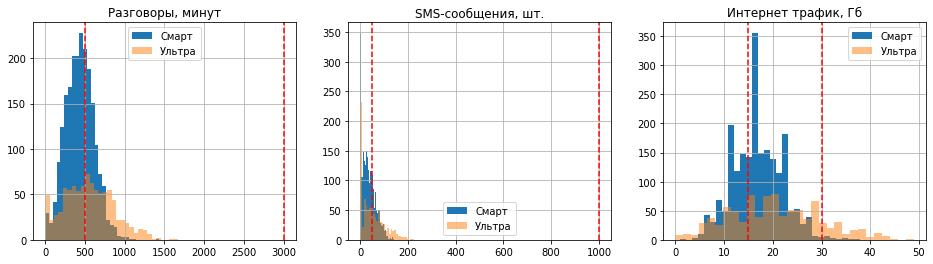

In [22]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
i = 0
tariffs['gb_included'] = tariffs['mb_per_month_included']/1024

for parameter, included_name in  {'minutes_tot' : 'minutes_included', 
                                  'messages_tot' : 'messages_included',
                                  'gb_used' : 'gb_included'
                                 }.items():
    users_with_all[users_with_all['tariff']=='smart'][parameter].hist(bins=30, density=False, ax=axes[i])
    users_with_all[users_with_all['tariff']=='ultra'][parameter].hist(bins=30, density=False, alpha=0.5, ax=axes[i])
    axes[i].legend(['Смарт', 'Ультра'])
    axes[i].axvline(tariffs.loc[0, included_name], linestyle='--', color='red')
    axes[i].axvline(tariffs.loc[1, included_name], linestyle='--', color='red')
    i += 1

axes[0].set_title('Разговоры, минут')
axes[1].set_title('SMS-сообщения, шт.')
axes[2].set_title('Интернет трафик, Гб')


Наблюдаются практически нормальные распредлеения для количества минут разговоров и израсходованного интернет трафика, распределения числа SMS-сообщений в первом приближении имеют форму распределения Пуассона, что и следовало ожидать.  
На гистограммах длительности разговоров и числа SMS-сообщений выделяют пики, соответствующие 0. Частично такие значения были добавлены при объединении данных, однако даже с учетом этого число нулевых значений велико - некоторые клиенты принципиально не пользуются SMS-сообщениями, а некоторые не разговаривают. Возможно такие клиенты используют сим-карту исключетельно для использования интернета (модемы, планшеты и т.д.).  
Распределения для обоих тарифов имеют похожую форму. Как было сказано при рассмотрении центральных моментов - для пользователей тарифа "Ультра" характерна большая диспресия значений расходов.  
Можно заметить, что по продложительности разговоров и числу сообщений пользователи тарифа "Ультра" не превышают лимитов красные линии), а по количеству интернет трафика зачастую превышают лимит, а кроме того стремяться выбрать весь лимит (второй максимум около 30 Гб).  
Пользователи тарифа "Смарт" часто превышают лимиты по всем трем направлениям.



## Анализ расходов пользователей

### Сравнение расходов пользователей разных тарифов

Оценим среднее значение и дисперсию месячных расходов для пользователей разных тарифов:

In [23]:
tariff_fees = users_with_all.pivot_table(index='tariff', values='total_monthly_fee', aggfunc=['mean', 'std']).round(1)
tariff_fees.columns =['Средняя плата', 'Стандартное отклонение']
tariff_fees

,Средняя плата,Стандартное отклонение
tariff,,
smart,1327.7,821.8
ultra,2078.1,387.1


Средняя месячная плата для пользователей тарифа "Ультра" в 1,5 раза превышает среднюю плату пользователей тарифа "Смарт", при этом стандартное отклонение для платы по тарифу "Ультра" существенно меньше чем по тарифу "Смарт".  
Это объясняется тем, что пользователи тарифа "Ультра" редко превышают бесплатные лимиты, поэтому средняя плата по тарифу близка к абонентской плате, а стандартное отклонение не велико. Рассмотрим гистограммы распределения месячной платы по тарифам. 

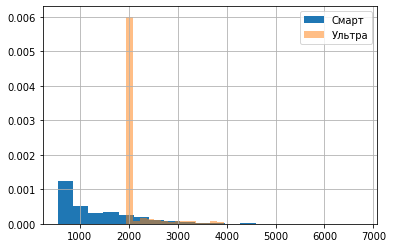

In [24]:
users_with_all[users_with_all['tariff']=='smart']['total_monthly_fee'].hist(bins=20, density=True, label='Смарт')
users_with_all[users_with_all['tariff']=='ultra']['total_monthly_fee'].hist(bins=20, density=True, alpha=0.5, label='Ультра')
plt.legend()

Среди пользователей тарифа "Ультра" практически все пользователи платят исключительно абонентскую плату. Среди пользователей тарифа "Смарт", платящие только абоненсткую плату также выделяются, но не столь сильно.
Проверим статистическую значимость гипотезы о том, что пользователи тарифа "Ультра" платят больше пользователей тарифа "Смарт", против нулевой гипотезы о равенстве месячных расходов пользователей обоих тарифов. Используем для этого двухвыборочных t-тест:

In [25]:
results = st.ttest_ind(users_with_all[users_with_all['tariff']=='smart']['total_monthly_fee'],
               users_with_all[users_with_all['tariff']=='ultra']['total_monthly_fee']
  
)
print("p-значение:", results.pvalue)

p-значение: 2.6059324173924516e-139


Полученное p-значение крайне мало, ниже любой разумной границы для отказа от нулевой гипотезы. Следовательно с очень большой уверенностью можно говорить о различии расходов пользователей различных тарифов.

### Сравнение расходов пользователей из разных городов

Согласно описанию проекта треуется сравнить расходы пользователей из Москвы и других городов. Рассмотрим гистограммы распределения расходов пользователей из Москвы и других городов:

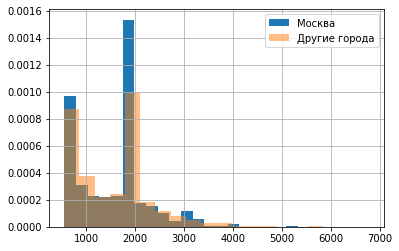

In [26]:
users_with_all[users_with_all['city']=='Москва']['total_monthly_fee'].hist(bins=20, density=True, label='Москва')
users_with_all[users_with_all['city']!='Москва']['total_monthly_fee'].hist(bins=20, density=True, alpha=0.5, label='Другие города')
plt.legend()

Как следует из гистограмм, распределения расходов для Москвы и других городов практически совпадают. Большая доля расходов около 2000 руб., по всей видимости связана с большей популярностью тарифа "Ультра" в Москве, по сравнению с другими городами. Можно предположить что расходы в Москве будут несколько больше, чем в других городах. Сравним средние расходы:

In [27]:
msc_fee = users_with_all[users_with_all['city']=='Москва']['total_monthly_fee'].mean()
not_msc_fee = users_with_all[users_with_all['city']!='Москва']['total_monthly_fee'].mean()
print(f"Средний расход пользователей в Москве: {msc_fee:0.1f}")
print(f"Средний расход пользователей в других городах: {not_msc_fee:0.1f}")

Средний расход пользователей в Москве: 1574.0
Средний расход пользователей в других городах: 1552.2


Средний расход в Москве действительно немного больше, чем в других городах. Проверим статистическую значимость такого различия:

In [28]:
results_msc = st.ttest_ind(users_with_all[users_with_all['city']=='Москва']['total_monthly_fee'],
             users_with_all[users_with_all['city']!='Москва']['total_monthly_fee']
            )
print("p-значение:", results_msc.pvalue)

p-значение: 0.5525551503378081


Вероятность случайно получить такое же или большее различие составляет ~0.55, следовательно гипотезу о различии расходов в Москве и других городах следует с большой уверенностью отклонить.

### Вывод

Пользователи тарифа "Ультра" редко превышают бесплатные лимиты, однако большая абоненстная плата приводит к значимому (p-значение $ 2,6\cdot 10^{-139} $) отличию средней месячной платы по тарифу "Ультра" по сравнению с тарифом "Смарт".  

Распределения расходов для клиентов из Москвы и других городов практически совпадают. Для Москвы характерна немного большая доля расходов около 2000 руб., по всей видимости связаная с большей популярностью тарифа "Ультра" в Москве.  
Статистически значимые различия в средних месячных расходах пользователей из Москвы и других городов отсутствуют (p-значение 0,55).

## Общий вывод

Наблюдаются практически нормальные распределения для количества минут разговоров и израсходованного интернет трафика, распределения числа SMS-сообщений для обоих тарифов.  
Некоторые клиенты не пользуются SMS-сообщениями, а некоторые не совершают звонки. Вероятно такие клиенты используют сим-карту исключетельно для использования интернета (модемы, планшеты и т.д.).  

Пользователи тарифа "Ультра" редко превышают бесплатные лимиты, однако большая абоненстная плата приводит к значимому (p-значение $ 2,6\cdot 10^{-139} $) отличию средней месячной платы по тарифу "Ультра" по сравнению с тарифом "Смарт". Средние месячные расходы клиентов по тарифам "Смарт" и "Ультра" составляют 1328 и 2078 руб. соответственно.  

Распределения расходов для клиентов из Москвы и других городов практически совпадают. Для Москвы характерна немного большая доля расходов около 2000 руб., по всей видимости связаная с большей популярностью тарифа "Ультра" в Москве.  
Статистически значимые различия в средних месячных расходах пользователей из Москвы и других городов отсутствуют (p-значение 0,55).